In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from PIL import Image
from IPython.display import display

import glob
import os
import matplotlib.pyplot as plt
import time

In [ ]:
"""class CNN(nn.Module):
    def __init__(self, num_classes=10, in_channels=3, num_conv_layers_to_use=None, freeze=True):
        super().__init__()
        base = models.vgg16(weights="DEFAULT")

        # Map "how many conv blocks to include" -> inclusive index in base.features
        # (These indices align with the ends of VGG16 conv blocks.)
        layers = {0: 0, 1: 2, 2: 7, 3: 14, 4: 21, 5: 28}

        feats = list(base.features.children())
        if num_conv_layers_to_use is None:
            cutoff = len(feats) - 1  # use full VGG16 features
        else:
            if num_conv_layers_to_use not in layers:
                raise ValueError(f"num_conv_layers_to_use must be one of {list(layers.keys())}")
            cutoff = layers[num_conv_layers_to_use]

        # Include the module at 'cutoff' (avoid off-by-one)
        self.features = nn.Sequential(*feats[:cutoff + 1])

        # Optional stem: map arbitrary input channels -> 3 channels expected by VGG16
        self.stem = nn.Identity()
        if in_channels != 3:
            self.stem = nn.Conv2d(in_channels, 3, kernel_size=1, bias=False)

        # Freeze or not the backbone actually being used
        for p in self.features.parameters():
            p.requires_grad = not freeze

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        # Compute flattened size dynamically
        dummy = torch.randn(1, in_channels, 224, 224)
        with torch.no_grad():
            f = self.features(self.stem(dummy))
            f = self.avgpool(f)
            flattened_size = f.view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

        # Grad-CAM target: explicitly pick the last Conv2d
        self.target_layer = self._get_last_conv(self.features)

    @staticmethod
    def _get_last_conv(module: nn.Module) -> nn.Conv2d:
        for m in reversed(list(module.modules())):
            if isinstance(m, nn.Conv2d):
                return m
        raise ValueError("No Conv2d found in features")

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [30]:
class CNN(nn.Module):
    def __init__(self, num_classes, freeze=True):
        super().__init__()

        vgg16 = models.vgg16(weights="DEFAULT")

        self.cnn = vgg16.features

        if freeze:
            for param in self.cnn.parameters():
                param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(25088, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        def _get_last_conv(module):
            for m in reversed(list(module.modules())):
                if isinstance(m, nn.Conv2d):
                    return m
            raise ValueError("No Conv2d found")
        
        self.target_layer = _get_last_conv(self.cnn)

    def forward(self, img):
        cnn_feat = self.cnn(img)
        return self.fc(cnn_feat)

In [4]:
class ViT(nn.Module):
    def __init__(self, num_classes, freeze=True):
        super().__init__()
        self.vit = models.vit_b_16(weights="DEFAULT")

        if freeze:
            for param in self.vit.parameters():
                param.requires_grad = False

        vit_output_dim = self.vit.heads.head.in_features

        self.vit.heads = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(vit_output_dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, img):
        vit_feat = self.vit(img)
        return self.fc(vit_feat)

In [5]:
train_data_dir = '/global/scratch/users/eliothuang/train_processed_dataset'
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

class_names = train_dataset.classes

print("Train dataset created successfully.")
print("Number of samples:", len(train_dataset))
print("Number of classes:", len(train_dataset.classes)) # Corrected to access classes directly
print("Class names:", class_names)

Train dataset created successfully.
Number of samples: 201448
Number of classes: 3
Class names: ['PE_1um_PBSxHEX_no lipids_1hr', 'PE_1um_PBSxHEX_with lipids_1hr', 'PS_1um_PBSxHEX_no lipids']


In [6]:
test_data_dir = '/global/scratch/users/eliothuang/test_processed_dataset'
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

class_names2 = test_dataset.classes

print("Train dataset created successfully.")
print("Number of samples:", len(test_dataset))
print("Number of classes:", len(test_dataset.classes)) # Corrected to access classes directly
print("Class names:", class_names2)

Train dataset created successfully.
Number of samples: 86336
Number of classes: 3
Class names: ['PE_1um_PBSxHEX_no lipids_1hr', 'PE_1um_PBSxHEX_with lipids_1hr', 'PS_1um_PBSxHEX_no lipids']


In [7]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=4)

In [8]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

In [17]:
def training_loop(model, train, test, num_epochs=10, learning_rate=1e-3):
    epoch_total_loss = []
    epoch_avg_loss = []
    epoch_accuracies = []
    test = []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    n = model.to(device)

    start = time.time()

    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0

        for full_img, labels in train_loader:
            full_img, labels = full_img.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(full_img)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            avg_loss = running_loss / len(train_loader)

        epoch_total_loss.append(running_loss)
        epoch_avg_loss.append(avg_loss)
        accuracy = evaluate(model, train_loader)
        epoch_accuracies.append(accuracy)
        
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")
        test_accuracy = evaluate(model = use_model, loader = test_loader)
        test.append(test_accuracy)
        print(f"Epoch {epoch+1}, Total Loss: {running_loss:.4f}, Avg Loss: {avg_loss:.4f} Train Accuracy: {accuracy:.2f}%, Test Accuracy: {test_accuracy} ")

    total_time = time.time() - total_start
    print(f"\nTraining completed in {total_time/60:.2f} minutes ({total_time:.2f} seconds).")
    return epoch_avg_loss, epoch_total_loss, epoch_accuracies, test

In [ ]:
use_model = CNN(num_classes=len(class_names), freeze=False)
WEIGHTS_PATH = '/global/home/users/eliothuang/weights/GRADCAMTEST_unfrozen_expandedCNN_weights.pt'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

try:
    state_dict = torch.load(WEIGHTS_PATH, map_location=device)
    use_model.load_state_dict(state_dict)
    print(f"Successfully loaded model weights from {WEIGHTS_PATH}")
except FileNotFoundError:
    print(f"Warning: Weights file not found at {WEIGHTS_PATH}. Starting training with random initialization.")
except RuntimeError as e:
    print(f"Error loading state_dict: {e}")
    print("This might happen if the model architecture does not match the saved weights.")
    print("Starting training with random initialization.")

print("Starting training...")
use_model.to(device)

epoch_avg_loss, epoch_running_loss, epoch_accuracies, test = training_loop(model = use_model,
                                               train = train_loader,
                                               test = test_loader,
                                               num_epochs=10, learning_rate = 1e-4)
print("Training finished.")

try:
    torch.save(use_model.state_dict(), WEIGHTS_PATH)
    print(f"Successfully saved updated model weights to {WEIGHTS_PATH}")
except Exception as e:
    print(f"Error saving model weights: {e}")

plt.figure()
plt.plot(range(1, len(epoch_avg_loss) + 1), epoch_avg_loss, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Avg Loss Over Epochs")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, len(epoch_running_loss) + 1), epoch_running_loss, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Running Loss Over Epochs")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, len(epoch_accuracies) + 1), [a for a in epoch_accuracies], marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train Accuracy Over Epochs")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, len(test) + 1), test, marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Over Epochs")
plt.grid(True)
plt.show()

Using device: cuda
Starting training...


In [ ]:
use_model = ViT(num_classes=len(class_names), freeze=True)
WEIGHTS_PATH = '/global/home/users/eliothuang/weights/expandedViT_weights.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    state_dict = torch.load(WEIGHTS_PATH, map_location=device)
    use_model.load_state_dict(state_dict)
    print(f"Successfully loaded model weights from {WEIGHTS_PATH}")
except FileNotFoundError:
    print(f"Warning: Weights file not found at {WEIGHTS_PATH}. Starting training with random initialization.")
except RuntimeError as e:
    print(f"Error loading state_dict: {e}")
    print("This might happen if the model architecture does not match the saved weights.")
    print("Starting training with random initialization.")

print("Starting training...")
use_model.to(device)
epoch_avg_loss, epoch_running_loss, epoch_accuracies, test = training_loop(model = use_model,
                                               train = train_loader,
                                               test = test_loader,
                                               num_epochs=10)

print(f"Test Accuracy: {evaluate(model = use_model, loader = test_loader)}")
print("Training finished.")

try:
    torch.save(use_model.state_dict(), WEIGHTS_PATH)
    print(f"Successfully saved updated model weights to {WEIGHTS_PATH}")
except Exception as e:
    print(f"Error saving model weights: {e}")

plt.figure()
plt.plot(range(1, len(epoch_avg_loss) + 1), epoch_avg_loss, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Avg Loss Over Epochs")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, len(epoch_running_loss) + 1), epoch_running_loss, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Running Loss Over Epochs")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, len(epoch_accuracies) + 1), [a for a in epoch_accuracies], marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train Accuracy Over Epochs")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, len(test) + 1), test, marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Over Epochs")
plt.grid(True)
plt.show()

Starting training...
Epoch 1, Total Loss: 192.8430, Avg Loss: 0.1225 Train Accuracy: 97.50%
Test Accuracy: 97.47729799851741 
Epoch 2, Total Loss: 96.0067, Avg Loss: 0.0610 Train Accuracy: 98.06%
Test Accuracy: 97.9348128243143 
Epoch 3, Total Loss: 74.4554, Avg Loss: 0.0473 Train Accuracy: 98.39%
Test Accuracy: 98.20816345441068 
Epoch 4, Total Loss: 61.8844, Avg Loss: 0.0393 Train Accuracy: 98.93%
Test Accuracy: 98.77339696071164 
Epoch 5, Total Loss: 54.9509, Avg Loss: 0.0349 Train Accuracy: 98.88%
Test Accuracy: 98.68768532246108 
Epoch 6, Total Loss: 48.1537, Avg Loss: 0.0306 Train Accuracy: 98.81%
Test Accuracy: 98.61471460340994 
Epoch 7, Total Loss: 43.9435, Avg Loss: 0.0279 Train Accuracy: 99.18%
Test Accuracy: 99.00041697553743 
Epoch 8, Total Loss: 39.9596, Avg Loss: 0.0254 Train Accuracy: 99.04%
Test Accuracy: 98.78034655300222 
Epoch 9, Total Loss: 36.5748, Avg Loss: 0.0232 Train Accuracy: 99.21%
Test Accuracy: 98.97725166790215 


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("PyTorch version:", torch.__version__)
print("CUDA device count:", torch.cuda.device_count())

In [14]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import numpy as np
img_path = "/global/scratch/users/eliothuang/all_processed_dataset/PE_1um_PBSxHEX_no lipids_1hr/Copy of 171420.973_90_890.bmp"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = use_model.to(device)
target_layers = [use_model.target_layer]
image = Image.open(img_path).convert("RGB")
rgb_img = np.float32(image) / 255.0 
transform = transforms.Compose([
    transforms.Resize((224, 224)),        # match your training size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

# image -> tensor WITH batch
input_tensor = transform(image).unsqueeze(0).to(device)

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

target_class_idx = class_names.index("PE_1um_PBSxHEX_with lipids_1hr") 
targets = [ClassifierOutputTarget(target_class_idx)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

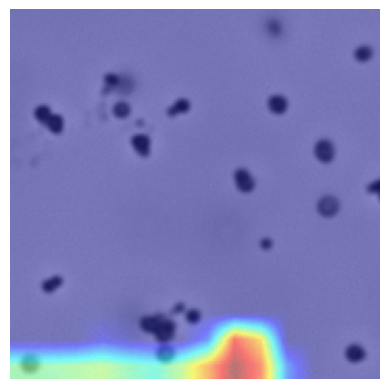

Saved to gradcam_overlay.png


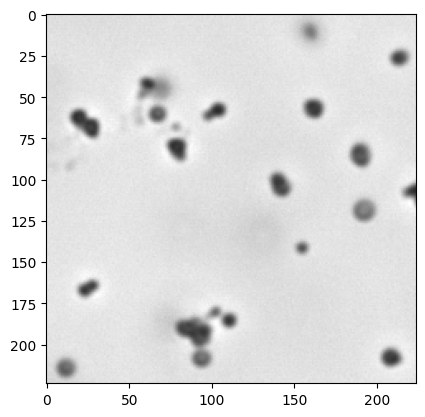

In [15]:
plt.imshow(visualization)
plt.axis("off")
plt.show()

# save if you want
Image.fromarray(visualization).save("gradcam_overlay.png")
print("Saved to gradcam_overlay.png")
plt.imshow(image)